In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed( 0 )
sns.set_style( "darkgrid" )

## Preprocessing/Cleaning

In [ ]:
df = pd.read_parquet("C:\\Users\\lselig\\selig-fa\\finance\\.data\\ratios.parquet")
print(df.shape)
print(df.describe())
print(list(df))
print(df.isna().sum())

# lots of missing values, these columns are missing most frequently (> 100k / 350k)
worst_offenders = ["totalDebtToCapitalization", "interestCoverage", "inventoryTurnover", "cashFlowCoverageRatios", "shortTermCoverageRatios",
                   "dividendPaidAndCapexCoverageRatio", "dividendPayoutRatio", "dividendYield"]

df.drop(columns = worst_offenders, inplace = True)
print(df.shape)

df.dropna(inplace = True)
print(df.shape)


qualitative_cols = ["symbol", "date", "period"]
qualitatives = df[qualitative_cols]
df.drop(columns = qualitative_cols, inplace = True)
print(df.shape)


In [33]:
features = df.to_numpy()
# features = df
scaler = StandardScaler()
features =  scaler.fit_transform(features)
features = np.clip(features, -5, 5)
print(features.shape)
n_features = features.shape[1]
print(n_features)
%matplotlib widget 
for i in range(n_features):
    print(i, np.nanmin(features[:, i]), np.nanmax(features[:, i]))
    sns.kdeplot(features[:, i])
plt.title("Distribution of final features")
plt.close()

(159849, 46)
46
0 -0.18705313550681496 5.0
1 -0.06765892826021787 5.0
2 -0.00842757338398135 5.0
3 -0.0035085976390046426 5.0
4 -0.0025015636018283793 5.0
5 -0.0025258095396071315 5.0
6 -0.0025483020329826935 5.0
7 -0.33513512791483124 5.0
8 -5.0 0.08766563018398148
9 -5.0 0.002506363485354956
10 -5.0 0.0025062999319441738
11 -5.0 0.002505271694677605
12 -5.0 5.0
13 -5.0 5.0
14 -5.0 5.0
15 -5.0 5.0
16 -2.42332125467385 5.0
17 -5.0 5.0
18 -5.0 0.002506363485378352
19 -5.0 5.0
20 -5.0 5.0
21 -5.0 5.0
22 -5.0 5.0
23 -5.0 5.0
24 -0.07953570597367676 5.0
25 -1.014892904645435 5.0
26 -0.12877671584377076 5.0
27 -0.2363888826256511 5.0
28 -5.0 5.0
29 -5.0 5.0
30 -0.0025958768300683144 5.0
31 -5.0 5.0
32 -5.0 0.00294901823912816
33 -5.0 5.0
34 -5.0 5.0
35 -5.0 5.0
36 -5.0 5.0
37 -0.0025031308409676155 5.0
38 -5.0 5.0
39 -5.0 5.0
40 -5.0 5.0
41 -5.0 5.0
42 -0.17109150623860672 5.0
43 -0.0025031308409676155 5.0
44 -5.0 0.0025115922232571406
45 -5.0 5.0


                                    currentRatio  quickRatio     cashRatio  \
currentRatio                        1.000000e+00   -0.000010 -1.023968e-05   
quickRatio                         -1.046226e-05    1.000000  7.420996e-01   
cashRatio                          -1.023968e-05    0.742100  1.000000e+00   
daysOfSalesOutstanding              4.709410e-05    0.000009  6.378883e-06   
daysOfInventoryOutstanding          1.021823e-05   -0.000002  5.605011e-06   
operatingCycle                      1.084174e-05   -0.000002  5.635607e-06   
daysOfPayablesOutstanding           1.127039e-05   -0.000002  5.677757e-06   
cashConversionCycle                 1.073832e-05   -0.000002  5.625408e-06   
grossProfitMargin                   1.630180e-05    0.000011  6.914527e-06   
operatingProfitMargin              -1.034645e-05    0.000002 -5.610647e-06   
pretaxProfitMargin                 -1.034536e-05    0.000002 -5.610520e-06   
netProfitMargin                    -1.031894e-05    0.000002 -5.

<AxesSubplot:>

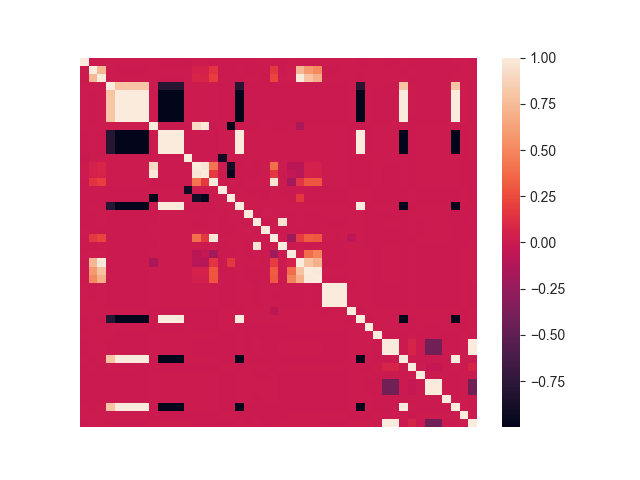

In [34]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot = False, xticklabels= False, yticklabels=False)


In [ ]:
print(features.shape)
pca = PCA(n_components=2)
pca.fit(features.T)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
components = pca.components_.T
print(components.shape)
# plt.close()
# plt.hist2d(components[:, 0], components[:, 1], bins = 100)
# plt.show()

(159849, 3)


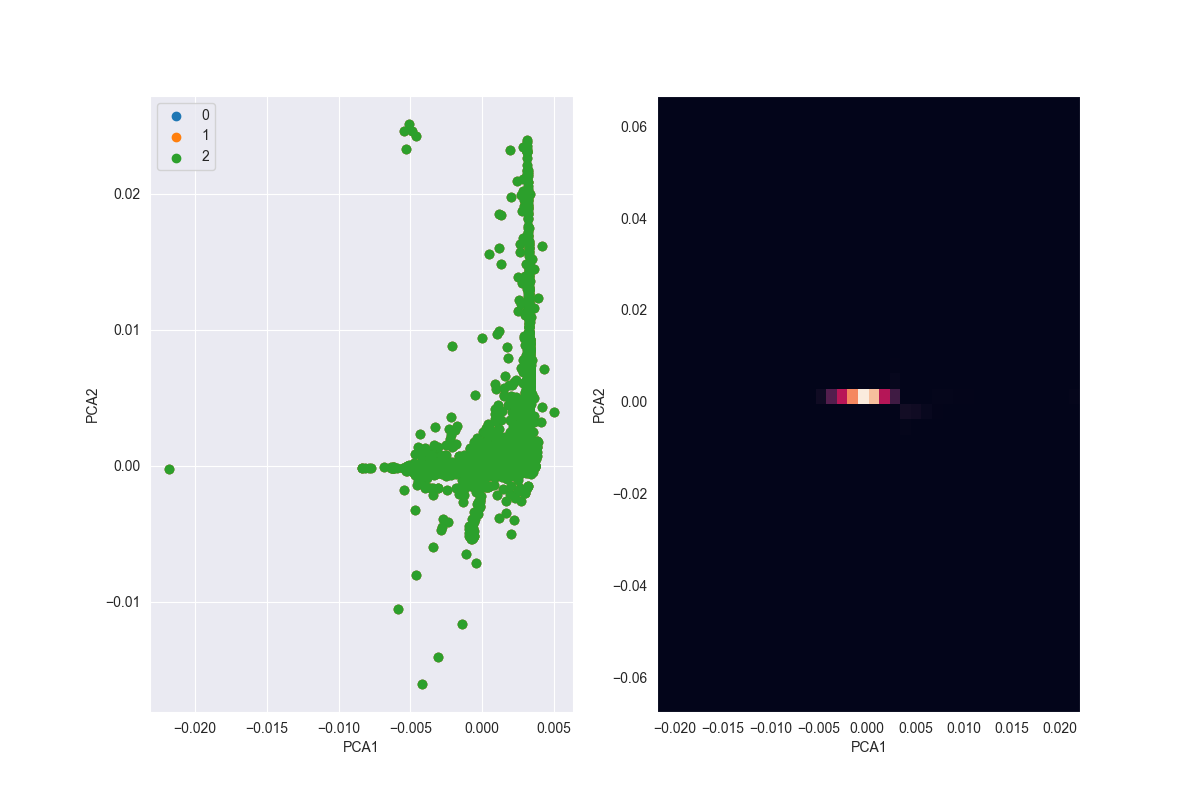

In [37]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

clst = KMeans(n_clusters=3, random_state=0).fit(components)
# clst = AffinityPropagation( random_state=0).fit(components)
labels = clst.labels_.reshape(-1, 1)
pca_and_labels = np.hstack((components, labels))
print(pca_and_labels.shape)
clst.labels_.shape
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
for g in np.unique(labels):
    idxs = np.where(pca_and_labels[:, 2] == g)[0]
    cluster = pca_and_labels[idxs]
    # print(cluster)
    # for i, c in enumerate(cluster):
    #     print(c[0], c[1], qualitatives[:, 0][idxs[i]])
    #     axs[0].text(c[0], c[1], s = qualitatives[:, 0][idxs[i]])
    axs[0].scatter(cluster[:, 0],  cluster[:, 1], label = g)
axs[0].set_xlabel("PCA1")
axs[0].set_ylabel("PCA2")
axs[1].hist2d(pca_and_labels[:, 0], pca_and_labels[:, 1], bins = 40)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("PCA2")
axs[0].legend()
plt.show()
